<a href="https://colab.research.google.com/github/Shelke99/GAN/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install tensorflow
!pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
print(tf.__version__)

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-rc0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-rc0
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.9.2


In [ ]:
#more importing common library
from tensorflow.keras.layers import  Input,Dense,LeakyReLU,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys,os 


In [ ]:
from tensorflow.python.ops.math_ops import xdivy
#load the mnist data
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
 
 #Scale the input in range of (-1,+1)for better treaning
x_train,x_test=x_train / 255.0 * 2 - 1,x_test/255.0 * 2 -1

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print("x_train.shape:" ,x_train.shape)
print("x_test.shape:" ,x_test.shape)


x_train.shape: (60000, 28, 28)
x_test.shape: (10000, 28, 28)


In [ ]:
#flatten the data
N,H,W = x_train.shape
D = H * W
x_train = x_train.reshape(-1,D)
x_test = x_test.reshape(-1,D)


In [ ]:
print("x_train.shape:" ,x_train.shape)
print("x_test.shape:" ,x_test.shape)

x_train.shape: (60000, 784)
x_test.shape: (10000, 784)


In [ ]:
# dimentionality of the latent space
latent_dim = 100

In [ ]:
# Difining the generator model
def build_generator(latent_dim):
  i = Input(shape = (latent_dim,))
  x = Dense(256,activation = LeakyReLU(alpha = 0.2))(i)
  x = BatchNormalization(momentum = 0.7)(x)
  x = Dense(512 , activation = LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i,x)
  return model

In [ ]:
#Difining a discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation =LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation = LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation = 'sigmoid')(x)
  model = Model(i, x)
  return model

In [ ]:
# compile both models in preparation for treaning 
 # Build and compile the discriminator
discriminator  =build_discriminator(D)
discriminator.compile (loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.5), metrics = ['accuracy'])

# Build and compile the combined model
generator =  build_generator(latent_dim)

In [ ]:
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 784)               4021

In [ ]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# creat an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))
z.shape

TensorShape([None, 100])

In [ ]:
# pass noise  through generator to get an image 
img = generator(z)

In [ ]:
img

<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'model_1')>

In [ ]:
# Make sure only the generator is trained

discriminator.trainable = False

In [ ]:
# the tru output is fake ,but we label them real !
# Passing the output of /generator to the discriminator
fake_pred = discriminator(img)

In [ ]:
#creat the combined model object
combined_model_gen = Model(z, fake_pred)


In [ ]:

#compile the combined model 
combined_model_gen.compile(loss = 'binary_crossentropy',optimizer = Adam(0.0002, 0.5))

In [ ]:
# config

batch_size = 32
epochs = 30000
sample_period = 200 # every smple_period steps generate and save some data"

In [ ]:
from tensorflow.python.ops.gen_batch_ops import batch
# Creat batch label to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# store the losses
d_losses = []
g_losses=[]

#Create folder to store generated images
if not os.path.exists('gen_images'):
    os.makedirs('gen_images')

In [ ]:
# A function to generate a grid of random samples from the generator and save them to a file

def sample_images(epoch):
  rows,cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)


  # rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs =plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W),cmap ='gray')
      axs[i,j].axis('off')
      idx += 1
      fig.savefig("gen_images/%d.png" % epoch)
      plt.close()

In [ ]:
# train the GAN

In [ ]:
#from numpy.random.mtrand import sample
# Main treaning loop
for epoch in range(epochs):
  
  # select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  #Generate  fake images
  noise = np.random.randn( batch_size, latent_dim)
  fake_imgs = generator. predict(noise)


  # Train the discriminator
  # both loss and accuracy are returened
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs,ones)
  d_loss_fake,d_acc_fake = discriminator.train_on_batch(fake_imgs,zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)


  ##########################
  ### Train  generator ###
  ################


  noise = np.random.randn(batch_size,latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)

# do it again  
  noise = np.random.randn(batch_size,latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)

  #save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)


  if epoch % 100 == 0:
   print(f"epoch: {epoch + 1}/{epochs},d_loss:{d_loss:.2f},\d_acc:{d_acc:.2f}, g_loss:{g_loss:.2f}")
    
  if epoch %  sample_period == 0:
    sample_images(epoch)




Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
epoch: 25101/30000,d_loss:0.60,\d_acc:0.59, g_loss:1.06
1/1 [==============================] - 0s 20ms/step
epoch: 25201/30000,d_loss:0.65,\d_acc:0.62, g_loss:1.01
1/1 [==============================] - 0s 20ms/step
epoch: 25301/30000,d_loss:0.74,\d_acc:0.52, g_loss:1.15
1/1 [==============================] - 0s 19ms/step
epoch: 25401/30000,d_loss:0.63,\d_acc:0.62, g_loss:1.07
1/1 [==============================] - 0s 18ms/step
epoch: 25501/30000,d_loss:0.61,\d_acc:0.66, g_loss:1.25
1/1 [==============================] - 0s 21ms/step
epoch: 25601/30000,d_loss:0.56,\d_acc:0.69, g_loss:0.93
1/1 [==============================] - 0s 25ms/step
epoch: 25701/30000,d_loss:0.62,\d_acc:0.72, g_loss:1.10
1/1 [==============================] - 0s 18ms/step
epoch: 25801/30000,d_loss:0.65,\d_acc:0.62, g_loss:1.23
1/1 [==============================] - 0s 21ms/step
epoch: 25901/30000,d_loss:0.58,\d

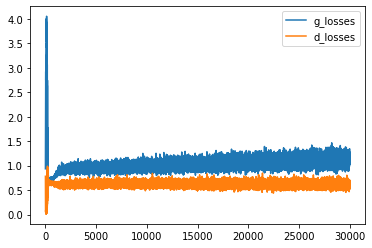

In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [ ]:
!ls gan_images

ls: cannot access 'gan_images': No such file or directory


In [ ]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)


FileNotFoundError: ignored

In [ ]:
a = imread('gan_images/1000.png')
plt.imshow(a)

In [ ]:
a = imread('gan_images/5000.png')
plt.imshow(a)

In [ ]:
a = imread('gan_images/10000.png')
plt.imshow(a)

In [ ]:
a = imread('gan_images/20000.png')
plt.imshow(a)

In [ ]:
a = imread('gan_images/29800.png')
plt.imshow(a)